In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

standard Encoder-Decoder architecture

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src,src_mask),src_mask,
                           tgt,tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src),src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt),memory, src_mask, tgt_mask)


Define standard linear + softmax generation step

In [4]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self,x):
        return F.log_softmax(self.proj(x), dim=-1)

make composed of a stack of  identical layers

In [6]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

Core encoder is a stack of layers 

In [8]:
class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self,x,mask):
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)

layer normalization

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(feature))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean) / (std + self.eps) + self.b_2

In [13]:
x = torch.tensor([1,2,3,4,6,8],dtype=torch.float32)
x

tensor([1., 2., 3., 4., 6., 8.])

In [14]:
x.mean(-1,keepdim=True)

tensor([4.])

In [15]:
x.std(-1,keepdim= True)

tensor([2.6077])

A residual connection followed by a layer norm.<br>
Note for code simplicity the norm is first as opposed to last.

In [17]:
class SubLayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x,sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

Encoder is made up of self-attn and feed forward (defined below)

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size,dropout),2)
        self.size = size
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x,mask):
        x = self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)
    

"Generic N layer decoder with masking."

In [19]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

Decoder is made of self-attn, src-attn, and feed forward (defined below

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn, src_attn, feed_forward,dropout):
        super(Decoder, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.dropout = nn.Dropout(dropout)
        self.sublayer = clone(SubLayerConnection(size,dropout),3)
        self.feed_forward = feed_forward
        
    def forward(self,x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x:self.self_attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x, lambda x:self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x, self.feed_forward)

#### modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. <br>
This masking, combined with fact that the output embeddings are offset by one position, <br>
ensures that the predictions for position i can depend only on the known outputs at positions less than i
.

In [35]:
def subsequent_mask(size):
    attn_shape = (1,size,size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [36]:
a = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])

In [37]:
print(np.triu(a,0),'\n','------------')
print(np.triu(a,1))

[[1 2 3]
 [0 5 6]
 [0 0 9]
 [0 0 0]] 
 ------------
[[0 2 3]
 [0 0 6]
 [0 0 0]
 [0 0 0]]


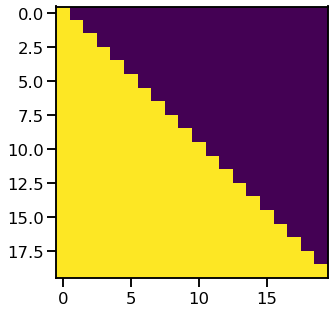

In [38]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### compute scaled dot-product attention

In [39]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query,key.transpose(-2,-1))/ math.sqrt(d_k)
    if mask is not None:
        score = scores.masked_fill(mask==0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
